## Image Classification on CIFAR-10 using a fully connected 2 layer network

In this note we train a fully connected 2 layer neural network for image classification. We use 2 type of loss functions: Mean Squared Error (MSE) and Cross Entropy Loss. First, let's import some packages

In [1]:
import pickle
import os
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

Here, a function is defined to extract the <em>CIFAR-10</em> dataset into Python dictionaries using <em>pickle</em>.

In [2]:
def unpickle(file):
    
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# defining an empty dictionary and a pairs of empty sets to be filled with CIFAR-10 training data
im_dict = {}
ims = []
lbs = []
#loading the batches of CIFAR-10 training data which is compressed in 5 files
for i in range(1,6):
    dict_temp = unpickle(f"data_batch_{i}")
    ims.append(dict_temp[b'data'])
    lbs.append(dict_temp[b'labels'])
ims = np.concatenate(ims)
lbs = np.concatenate(lbs)

im_dict[b'data'] = ims
im_dict[b'labels'] = lbs

#loading the batch containing CIFAR-10 testing data
t_dict = unpickle('test_batch')


print(f'dimension of input data: {ims[0].shape}')
print(f'number of training data: {len(lbs)}')
print(f"number of testing data: {len(t_dict[b'labels'])}")

dimension of input data: (3072,)
number of training data: 50000
number of testing data: 10000


Next, a custom dataset is created to retrieves our dataset’s features and labels one sample at a time for PyTorch. The functions <code>\_\_init__</code>, <code>\_\_len__</code> and <code>\_\_getitem__</code> are defined below. The first dataset <code>CustomImageDataset</code> gives labels as an integer number which is used for Cross Entropy Loss. The second dataset <code>CustomImageDataset_1hot</code> inherents <code>\_\_init__</code> and <code>\_\_len__</code> from the first dataset, but <code>\_\_getitem__</code> is modified such that the labels are retrived as one hot vectors to be used with MSE loss function.

In [3]:
from torchvision.transforms import ToTensor, Lambda
from torch.nn.functional import one_hot
class CustomImageDataset(Dataset):
    def __init__(self, img_dict, transform=None, target_transform=None):
        self.img_labels = img_dict[b'labels']
        self.img_list = img_dict[b'data']
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        #since the image data is flattened, here it's reshaped and transposed so it could be viewd as an RGB image
        image = torch.from_numpy(self.img_list[idx].reshape(3, 32, 32).transpose(1, 2, 0).astype(np.float32))
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
class CustomImageDataset_1hot(CustomImageDataset):

    def __getitem__(self, idx):
        #since the image data is flattened, here it's reshaped and transposed so it could be viewd as an RGB image
        image = torch.from_numpy(self.img_list[idx].reshape(3, 32, 32).transpose(1, 2, 0).astype(np.float32))
        label_num = torch.tensor(self.img_labels[idx])
        label = one_hot(label_num,num_classes=10).to(torch.float32)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Using PyTorch's dataloader API, minibatches of the training and test data are sampled. The data reshuffles at every epoch to reduce model overfitting.

In [4]:
from torch.utils.data import DataLoader

train_dataloader_1hot = DataLoader(CustomImageDataset_1hot(im_dict), batch_size=64, shuffle=True)
test_dataloader_1hot = DataLoader(CustomImageDataset_1hot(t_dict), batch_size=64, shuffle=True)

train_dataloader = DataLoader(CustomImageDataset(im_dict), batch_size=64, shuffle=True)
test_dataloader = DataLoader(CustomImageDataset(t_dict), batch_size=64, shuffle=True)

Now, let's retrive a minibatch from <code>train_dataloader_1hot</code> dataloader, look at check its dimensions, view its first image and the coresponding label:

Feature batch shape: torch.Size([64, 32, 32, 3])
Labels batch shape: torch.Size([64, 10])


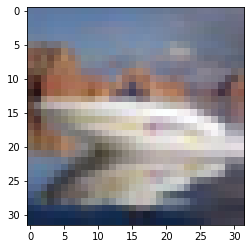

Label: ship


In [5]:
train_features, train_labels = next(iter(train_dataloader_1hot))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.type(torch.uint8))
plt.show()
label_dict = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 
              5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
print(f"Label: {label_dict[label.argmax().item()]}")

Then, the neural network is defined subclassing <code>nn.Module</code>, and initialize the neural network layers in <code>\_\_init__</code>. The network defined here has 1 hidden layer with 512 nodes. In <code>forward</code> function, the input is first transposed to a 2-dimentional tensor (keeping the batch size getting rid of all other dimensions) and then passes through the network.

In [6]:
from torch import nn
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3072, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

The training loop passes the training batch throgh the network, computes the loss and gradients, optimizes the parameters and keeps the history of loss function value. The test loop passes the testing batch throgh the network (without computing the gradients) and keeps the history of loss function value on test data.

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer,write_freq,loss_hist):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % write_freq == 0:
            loss_hist.append(loss.item())
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, one_hotness,loss_hist):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            if one_hotness:
                correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
            else:
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    loss_hist.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

<code>device</code> is created to represent the hardware used for the calculations. An instance of the class <code>NeuralNetwork</code> is created in <code>model</code> which is moved to <code>device</code>.

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralNetwork().to(device)

Let's see the results for MSE loss function first in 20 epochs using learning rate and regularization strength set for the SGD optimizer.

In [9]:
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=2e-5,weight_decay=2e-2)

epochs = 20
training_losses = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader_1hot, model, loss_fn, optimizer,200,training_losses)
    test_loop(test_dataloader_1hot, model, loss_fn, True,test_losses)
print("Done!")

Epoch 1
-------------------------------
loss: 144.333832  [    0/50000]
loss: 1.039691  [12800/50000]
loss: 0.592519  [25600/50000]
loss: 0.467383  [38400/50000]
Test Error: 
 Accuracy: 13.0%, Avg loss: 0.386928 

Epoch 2
-------------------------------
loss: 0.350706  [    0/50000]
loss: 0.281370  [12800/50000]
loss: 0.279879  [25600/50000]
loss: 0.244724  [38400/50000]
Test Error: 
 Accuracy: 14.5%, Avg loss: 0.228383 

Epoch 3
-------------------------------
loss: 0.195557  [    0/50000]
loss: 0.189030  [12800/50000]
loss: 0.185631  [25600/50000]
loss: 0.184707  [38400/50000]
Test Error: 
 Accuracy: 15.6%, Avg loss: 0.176446 

Epoch 4
-------------------------------
loss: 0.186036  [    0/50000]
loss: 0.205691  [12800/50000]
loss: 0.157158  [25600/50000]
loss: 0.136187  [38400/50000]
Test Error: 
 Accuracy: 16.2%, Avg loss: 0.148791 

Epoch 5
-------------------------------
loss: 0.215473  [    0/50000]
loss: 0.134027  [12800/50000]
loss: 0.121552  [25600/50000]
loss: 0.115816  [384

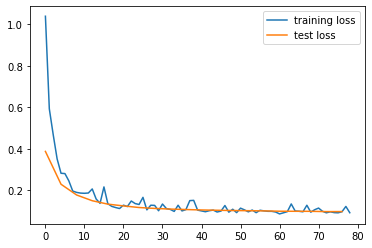

In [10]:
import matplotlib.pyplot as plt

plt.plot(training_losses[1:],label='training loss')
plt.plot(range(0,len(test_losses)*4,4),test_losses,label='test loss')
plt.legend(loc='upper right')

Now let's see the results for Cross Entropy loss function using similar set of hyper parameters.

In [11]:
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=2.5e-4,weight_decay=2e-2)



epochs = 20
training_losses = []
test_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer,100,training_losses)
    test_loop(test_dataloader, model, loss_fn, False,test_losses)
print("Done!")

Epoch 1
-------------------------------
loss: 12.094016  [    0/50000]
loss: 1.972775  [ 6400/50000]
loss: 1.888732  [12800/50000]
loss: 2.110047  [19200/50000]
loss: 1.812016  [25600/50000]
loss: 2.105644  [32000/50000]
loss: 2.014649  [38400/50000]
loss: 1.770256  [44800/50000]
Test Error: 
 Accuracy: 32.8%, Avg loss: 1.917521 

Epoch 2
-------------------------------
loss: 1.935292  [    0/50000]
loss: 1.750396  [ 6400/50000]
loss: 1.830021  [12800/50000]
loss: 1.645917  [19200/50000]
loss: 1.838982  [25600/50000]
loss: 1.797048  [32000/50000]
loss: 1.778003  [38400/50000]
loss: 1.539320  [44800/50000]
Test Error: 
 Accuracy: 30.4%, Avg loss: 1.986502 

Epoch 3
-------------------------------
loss: 1.850199  [    0/50000]
loss: 1.424531  [ 6400/50000]
loss: 1.661203  [12800/50000]
loss: 1.614971  [19200/50000]
loss: 1.599443  [25600/50000]
loss: 1.656002  [32000/50000]
loss: 1.668326  [38400/50000]
loss: 1.532464  [44800/50000]
Test Error: 
 Accuracy: 35.6%, Avg loss: 1.827611 

Epo

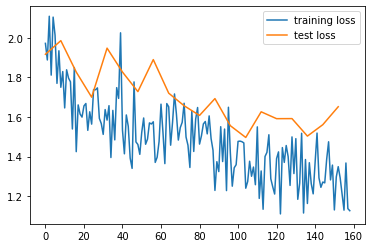

In [12]:
plt.plot(training_losses[1:],label='training loss')
plt.plot(range(0,len(test_losses*8),8),test_losses,label='test loss')
plt.legend(loc='upper right')